In [25]:
import sys
import importlib
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append('../code/')
import rf_regression as rfr
import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn import metrics
from matplotlib import ticker
import combat

In [2]:
# fn = 'data.xlsx' #insert actual data here 

df = pd.read_excel(fn)

In [3]:
pass_mock_df = df[df["mock_status"].isin(["pass"])]
pass_mock_df = df[df["MPRAGE"].isin(["pass", "maybe", "fail"])]

In [5]:
subset_features = ['age', 'verbal_iq', 'nonverbal_iq',\
                   'ados_rrb', 'ados_sa', \
                   'swan_inattention', 'swan_total_hype',\
                   'cbcl_int', 'cbcl_ext',\
                   'Eval1_SRS2P_TotT', \
                   'SEQ_seeking', 'SEQ_hypo', 'SEQ_hyper',\
                   'RBSR_6_StereoTot', 'RBSR_6_CompulsiveTot', 'RBSR_6_RitualTot',\
                   'RBSR_6_SameTot', 'RBSR_6_RestrictTot',\
                   '6min_meanFD', 'mock_count', \
                   'MPRAGE', 'REST1', 'FACES1', 'FACES2', 'REST2', 'T2_SPACE', 'DTI', 'site_id']
feature_df = pass_mock_df[subset_features] 
feature_df = feature_df.dropna()
feature_df = feature_df.reset_index()

In [7]:
mprage_status = pass_mock_df['MPRAGE'].values
rest1_status = pass_mock_df['REST1'].values
mprage_status = rfr.get_binary_passfail(mprage_status)
rest1_status = rfr.get_binary_passfail(rest1_status)
y_r1 = rest1_status*mprage_status


In [10]:
mprage_status = feature_df['MPRAGE'].values
rest1_status = feature_df['REST1'].values
rest2_status = feature_df['REST2'].values
faces1_status = feature_df['FACES1'].values
faces2_status = feature_df['FACES2'].values
t2_status = feature_df['T2_SPACE'].values
dti_status = feature_df['DTI'].values

mprage_status = rfr.get_binary_passfail(mprage_status)
rest1_status = rfr.get_binary_passfail(rest1_status)
rest2_status = rfr.get_binary_passfail(rest2_status)
faces1_status = rfr.get_binary_passfail(faces1_status)
faces2_status = rfr.get_binary_passfail(faces2_status)
t2_status = rfr.get_binary_passfail(t2_status)
dti_status = rfr.get_binary_passfail(dti_status)

In [11]:
faces_status = 1*((faces1_status + faces2_status) > 0)

In [12]:
y_t1 = mprage_status
y_r1 = rest1_status*mprage_status
y_f = faces_status*rest1_status*mprage_status
y_r2 = rest2_status*faces_status*rest1_status*mprage_status
y_t2 = t2_status*rest2_status*faces_status*rest1_status*mprage_status
y_dti = dti_status*t2_status*rest2_status*faces_status*rest1_status*mprage_status

In [13]:
len(y_t1)

190

In [14]:
print(np.sum(y_t1))
print(np.sum(y_r1))
print(np.sum(y_f))
print(np.sum(y_r2))
print(np.sum(y_t2))
print(np.sum(y_dti))


178
160
117
93
61
19


In [15]:
20/201

0.09950248756218906

In [16]:
print(np.sum(y_t1))
print(np.sum(y_r1))
print(np.sum(y_f))
print(np.sum(y_r2))
print(np.sum(y_t2))
print(np.sum(y_dti))


178
160
117
93
61
19


In [17]:
len(y_r1)

190

In [18]:
y_regression = y_t1 + y_r1 + y_f + y_r2 + y_t2 + y_dti

In [19]:
len(y_regression)

190

# Regression 

In [20]:
sitelist = feature_df['site_id'].values

subset_features = ['age', 'verbal_iq', 'nonverbal_iq',\
                   'ados_rrb', 'ados_sa', \
                   'swan_inattention', 'swan_total_hype',\
                   'cbcl_int', 'cbcl_ext',\
                   'Eval1_SRS2P_TotT', \
                   'SEQ_seeking', 'SEQ_hypo', 'SEQ_hyper',\
                   'RBSR_6_StereoTot', 'RBSR_6_CompulsiveTot', 'RBSR_6_RitualTot',\
                   'RBSR_6_SameTot', 'RBSR_6_RestrictTot',\
                   '6min_meanFD', 'mock_count']

x_df = feature_df[subset_features]
ebat = combat.combat(x_df.T, sitelist)
x_df = ebat.T

feature_names=subset_features
features_list = x_df.to_numpy()
print(features_list.shape)

Adjusting data
(190, 20)


found 2 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


In [21]:
rf = RandomForestRegressor(n_estimators=300)
skf = KFold(n_splits=5, shuffle=True)
num_of_loops = 100

run_total = num_of_loops*5

ytestlist = [] 
ypredlist = [] 

importance_mat = np.zeros((len(subset_features), run_total))
mae_list = np.zeros((run_total))
rsquared_list = np.zeros((run_total))
accuracylist = [] 
precisionlist = [] 
stddevlist = [] 

n=0
for loop_ind in range(0, num_of_loops): 
    for train_index, test_index in skf.split(features_list, y_regression):
    
        X_train = features_list[train_index, :]
        X_test = features_list[test_index, :]
        y_train = y_regression[train_index]
        y_test = y_regression[test_index]
       
        rf.fit(X_train, y_train)
        imp = rfpimp.importances(rf, pd.DataFrame(X_test, columns=subset_features), pd.DataFrame(y_test)) # permutation
        foo = imp.reindex(subset_features).values
        imp = foo.flatten()
        importance_mat[:, n] = imp

        y_pred = rf.predict(X_test) 

        mae = metrics.mean_absolute_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        mae_list[n] = (mae)
        rsquared_list[n] = (r2)
        n = n + 1
        ytestlist.append(y_test)
        ypredlist.append(y_pred)
        y_pred = np.round(y_pred)
        
        n_counter = 0 
        for n_accuracy in range(0, len(y_pred)): 
            if y_test[n_accuracy] == y_pred[n_accuracy]: 
                n_counter = n_counter + 1 
                
        accuracylist.append(n_counter/len(y_pred))
        stddevlist.append(np.std(y_pred))

In [22]:
y_pred

array([3., 3., 3., 4., 4., 3., 3., 4., 3., 3., 3., 3., 2., 2., 4., 3., 4.,
       3., 2., 3., 4., 2., 2., 4., 5., 3., 2., 3., 3., 2., 2., 3., 3., 3.,
       4., 2., 4., 4.])

In [23]:
feature_names = ['Age', 'Verbal IQ', 'Nonverbal IQ',\
                   'ADOS-2 RRB', 'ADOS-2 SA', \
                   'SWAN Inattention', 'SWAN Total Hype',\
                   'CBCL Internalizing', 'CBCL Externalizing',\
                   'SRS-2 Parent', \
                   'SEQ Seeking', 'SEQ Hypo', 'SEQ Hyper',\
                   'RBS-R Stereo', 'RBS-R Compulsive', 'RBS-R Ritual',\
                   'RBS-R Sameness', 'RBS-R Restrict',\
                   '6 Min Mean FD', 'Mock Count']

['Age' 'Verbal IQ' 'ADOS-2 RRB' 'SWAN Inattention' 'Mock Count'
 'CBCL Internalizing' 'ADOS-2 SA' '6 Min Mean FD' 'SEQ Hyper'
 'RBS-R Restrict' 'SWAN Total Hype' 'RBS-R Stereo' 'SRS-2 Parent'
 'RBS-R Compulsive' 'Nonverbal IQ' 'SEQ Hypo' 'CBCL Externalizing'
 'RBS-R Ritual' 'SEQ Seeking' 'RBS-R Sameness']


<IPython.core.display.Javascript object>


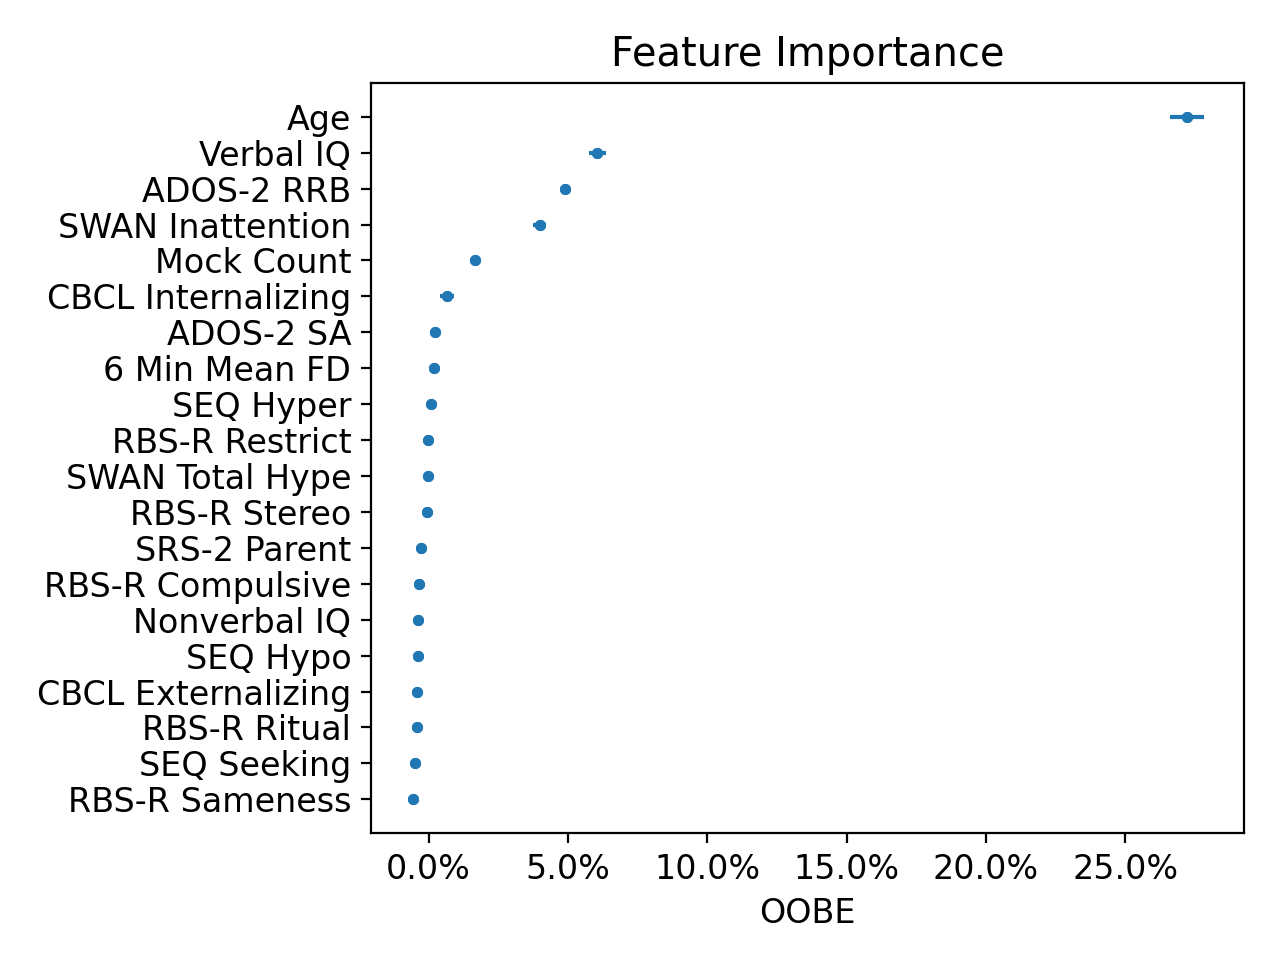

sorted oob percentages: 
[ 2.72193111e+01  6.05594710e+00  4.89389884e+00  3.98375728e+00
  1.65747187e+00  6.53660305e-01  2.29038742e-01  2.12057889e-01
  1.00393435e-01 -1.29473755e-02 -2.27203854e-02 -5.03620754e-02
 -2.72240492e-01 -3.50505580e-01 -3.86173524e-01 -3.86403112e-01
 -4.07623963e-01 -4.16665692e-01 -4.67535208e-01 -5.41298649e-01]


In [28]:
feature_names = np.array(feature_names)
feature_importance_vec = np.mean(importance_mat, 1)
feat_imp_sd = np.std(importance_mat, 1)
feat_imp_se = feat_imp_sd / np.sqrt(importance_mat.shape[1])


inds = np.flip(np.argsort(feature_importance_vec))
sorted_feature_vals = np.flip(np.sort(feature_importance_vec))
sorted_feature_name = feature_names[inds]
print(sorted_feature_name) 

fig, ax = plt.subplots()
x_values = sorted_feature_vals*100
y_values = np.flip(list(range(0, len(feature_names))))

ax.plot(x_values, y_values, '.')
ax.errorbar(x_values, y_values, xerr=feat_imp_se*100, fmt='.', color="C0")

plt.title('Feature Importance')
plt.yticks(np.flip(list(range(0, len(feature_names)))), sorted_feature_name)
plt.xlabel('OOBE')
plt.tight_layout()
plt.rcParams.update({'font.size': 12})
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()
plt.tight_layout()

print("sorted oob percentages: ") 
print(sorted_feature_vals*100)

In [ ]:
feature_names

In [31]:
print("sorted oob percentages: ") 
print(sorted_feature_vals*100)

sorted oob percentages: 
[ 2.72193111e+01  6.05594710e+00  4.89389884e+00  3.98375728e+00
  1.65747187e+00  6.53660305e-01  2.29038742e-01  2.12057889e-01
  1.00393435e-01 -1.29473755e-02 -2.27203854e-02 -5.03620754e-02
 -2.72240492e-01 -3.50505580e-01 -3.86173524e-01 -3.86403112e-01
 -4.07623963e-01 -4.16665692e-01 -4.67535208e-01 -5.41298649e-01]


In [35]:
print("MAE:", np.mean(mae_list))
print("R Squared:", np.mean(rsquared_list))


MAE: 1.3018305263157894
R Squared: 0.1631346273250711


In [36]:
np.mean(accuracylist)

0.2164736842105263